In [30]:
# Basic
import gym
import numpy as np
import pandas as pd
import os
import sys
import pickle
from time import sleep
from collections import namedtuple, OrderedDict, deque
from typing import List, Dict, NoReturn, Tuple, Optional, Any

# Visualization pretty
from pprint import pprint
from tqdm.notebook import tqdm_notebook
from IPython.display import clear_output

# NNs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Configue GPU

In [14]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_gpu = torch.cuda.device_count()
    print(device, n_gpu)
    torch.cuda.get_device_name(0) 
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

cpu


## Environment

**Description:** <br>
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
        
**Source:** <br>
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
        
**Observation:** <br>
        Type: Box(4) <br>
        
| Num | Observation | Min | Max |
| --- | --- | --- | --- |
| 0 | Cart Position          |   -4.8                 |  4.8 |
| 1 | Cart Velocity          |  -Inf                  |  Inf |
| 2 | Pole Angle             |   -0.418 rad (-24 deg) |  0.418 rad (24 deg) |
| 3 | Pole Angular Velocity  |   -Inf                 |  Inf |
        
**Actions:** <br>
        Type: Discrete(2) <br>
        Num   Action <br>
* 0     Push cart to the left
* 1     Push cart to the right

> Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
        
**Reward:** <br>
        Reward is 1 for every step taken, including the termination step
        
**Starting State:** <br>
        All observations are assigned a uniform random value in [-0.05..0.05]
        
**Episode Termination:** <br>
* Pole Angle is more than 12 degrees.
* Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
* Episode length is greater than 200.
* Solved Requirements:
* Considered solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.

In [3]:
# loading Cartpole environment from gym
env = gym.make('CartPole-v1')
env.seed(seed=11)
print(f"Action space: {env.action_space.n}")  
# Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
print(f"Observation space: shape {env.observation_space.shape},\n{env.observation_space.low} to {env.observation_space.high}")

Action space: 2
Observation space: shape (4,),
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] to [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [4]:
# Show sime random episodes
try:
    env.reset()
    for _ in range(200):
        env.render(mode='human')
        clear_output(wait=True)
        env.step(env.action_space.sample()) # take a random action
finally:
    env.close()

## Agent
Implements classical architecture for CEM method with weights evolution.

In [14]:
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

In [91]:
class CEM_Agent(nn.Module):
    
    def __init__(self, env, device, h_size: int = 16):
        super(CEM_Agent, self).__init__()
        self._env = env
        # state, hidden layer, action sizes
        if len(env.observation_space.shape) == 0:
            self._state_size = env.observation_space.n
        else:
            self._state_size = env.observation_space.shape[0]
        self._hidd_size = h_size
        if len(env.action_space.shape) == 0:
            self._act_size = env.action_space.n
        else:
            self._act_size = env.action_space.shape[0]
        self._device = device
        print(f"State size: {self._state_size}, action size: {self._act_size}")
        # define net
        self._net = nn.Sequential(OrderedDict([
            ("fc1", nn.Linear(self._state_size, self._hidd_size)),
            ("relu", nn.ReLU()),
            ("fc2", nn.Linear(self._hidd_size, self._act_size))
        ])).to(self._device)
        self.__n_params = self._count_parameters()
        
        
    def _count_parameters(self) -> int:
        return np.sum([c._parameters.get('weight').data.flatten().shape[0] +
                       c._parameters.get('bias').data.flatten().shape[0]
                       for i, c in self._net.named_children() 
                       if len(c._parameters.keys()) > 0])
                
        
    def set_weights(self, weights: np.ndarray):
        assert(weights.shape[0] == self.__n_params)
        layers = dict(self._net.named_children())
        fc1_end = (self._state_size * self._hidd_size) + self._hidd_size
        # fc1
        fc1_w = torch.from_numpy(weights[:self._state_size * self._hidd_size].reshape(self._hidd_size, 
                                                                                      self._state_size)).to(self._device)
        fc1_b = torch.from_numpy(weights[(self._state_size * self._hidd_size):
                                         fc1_end].reshape(self._hidd_size)).to(self._device)
#         print(f"fc1 weights: {fc1_w.shape}, bias: {fc1_b.shape}, fc1_end: {fc1_end}")
        layers.get('fc1')._parameters.get('weight').data.copy_(fc1_w) # .view_as(layers.get('fc1')._parameters.get('weight').data)
        layers.get('fc1')._parameters.get('bias').data.copy_(fc1_b)
        # fc2
        fc2_w = torch.from_numpy(weights[fc1_end: fc1_end + self._act_size * self._hidd_size].reshape(self._act_size, 
                                                                                        self._hidd_size)).to(self._device)
        fc2_b = torch.from_numpy(weights[fc1_end + (self._act_size * self._hidd_size) 
                                         :].reshape(self._act_size)).to(self._device)
#         print(f"fc2 weights: {fc2_w.shape}, bias: {fc2_b.shape}")
        layers.get('fc2')._parameters.get('weight').data.copy_(fc2_w) 
        layers.get('fc2')._parameters.get('bias').data.copy_(fc2_b)
        
        
    def forward(self, x) -> np.ndarray:
        return F.tanh(self._net(x.float().to(self._device))).cpu().data
    
    
    def evaluate(self, weights: np.ndarray, gamma: float = 1.0, 
                 max_iters: int = 1000) -> float:
        # set given weights
        self.set_weights(weights)
        # run replay
        episode_reward = 0.0
        state = self._env.reset()
        for t in range(max_iters):
            state = torch.from_numpy(state).float().to(self._device)
            action = torch.argmax(self.forward(state)).numpy()
            state, reward, done, _ = self._env.step(action)
            episode_reward += reward * np.power(gamma, t)
            if done:
                break
        return episode_reward

In [36]:
net = nn.Sequential(OrderedDict([
    ("fc1", nn.Linear(env.observation_space.shape[0], 10)),
    ("relu", nn.ReLU()),
    ("fc2", nn.Linear(16, env.action_space.n))
]))
for i, c in net.named_children():
    if len(c._parameters.keys()) > 0:
        print()
        print(c._parameters.get('weight').data.shape, "-->", c._parameters.get('weight').data.flatten().shape)
        print(c._parameters.get('bias').data.shape, "-->", c._parameters.get('bias').data.flatten().shape)

Sequential(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

## Train the Agent with the Cross-Entropy Method

In [95]:
def save_agent_weights(model: nn.Module, dir: str='models-checkpoints',
               filename: str='agent.pt'):
    """
    Trained model, configuration and tokenizer,
    they can then be reloaded using `from_pretrained()` if using default names.
    """
    # Take care of distributed/parallel training
    model_to_save = model.module if hasattr(model, 'module') else model.state_dict()
    torch.save(model_to_save, os.path.join(sys.path[0], dir, filename))
    # models_checkpoints
    print("Weights successfully saved.")
    

def CEM_Weights(agent: nn.Module, n_train_iterations: int = 500, 
                max_eval_iterations: int = 1000, train_gamma: float = 1.0, 
                log_interval: int = 10, population_size: int = 50, 
                elite_frac: float = 0.2, sigma: float = 0.5):
    """
    PyTorch implementation of the cross-entropy method.
    
    :param n_train_iterations (int): maximum number of training iterations
    :param max_eval_iterations (int): maximum number of timesteps per episode
    :param train_gamma (float): discount rate on train
    :param log_interval (int): how often to print average score (over last 100 episodes)
    :param population_size (int): size of population at each iteration
    :param elite_frac (float): percentage of top performers to use in update
    :param sigma (float): standard deviation of additive noise
    """
    n_elite = int(population_size * elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma * np.random.randn(agent._count_parameters())
    best_reward = 0.0
    
    for iteration in tqdm_notebook(range(1, n_train_iterations + 1)):
        # Generate population of weights distributions close to best one
        weights_population = [best_weight + (sigma * np.random.randn(agent._count_parameters())) 
                              for _ in range(population_size)]
        # Evaluate agents with weights from population and collect rewards
        rewards = np.array([agent.evaluate(weights, gamma=train_gamma, max_iters=max_eval_iterations) 
                            for weights in weights_population])
        # Select elite
        elite_idxs = rewards.argsort()[-n_elite:] # indexes of elite
        elite_weights = [weights_population[i] for i in elite_idxs]
        # Calculate best weights as mean of all elite weights
        best_weight = np.array(elite_weights).mean(axis=0)
        
        reward = agent.evaluate(best_weight, gamma=1.0, max_iters=max_eval_iterations)
        scores_deque.append(reward)
        scores.append(reward)
        if best_reward < reward:
            best_reward = reward
            save_agent_weights(agent, filename='cem_weights_agent.pt')
            
        if (iteration % log_interval) == 0:
            print(f"Episode {iteration}\tAverage Score: {round(np.mean(scores_deque), 2)}")

        if np.mean(scores_deque) >= 395.0:
            print(f'\nEnvironment solved in {iteration} iterations!')
            print(f"Average Score: {round(np.mean(scores_deque), 2)}")
            print(f"Best Score: {round(best_reward, 2)}")
            break
            
    return scores

In [96]:
# Create Agent
agent = CEM_Agent(env, device=device, h_size=10)
agent

State size: 4, action size: 2


CEM_Agent(
  (_net): Sequential(
    (fc1): Linear(in_features=4, out_features=10, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=10, out_features=2, bias=True)
  )
)

C:\Users\airen\Anaconda3\envs\pycharmenv\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Weights successfully saved.
Weights successfully saved.
Weights successfully saved.
Weights successfully saved.
Weights successfully saved.
Episode 10	Average Score: 111.7
Weights successfully saved.
Episode 20	Average Score: 305.85
Episode 30	Average Score: 370.57

Environment solved in 37 iterations!
Average Score: 395.05
Best Score: 500.0


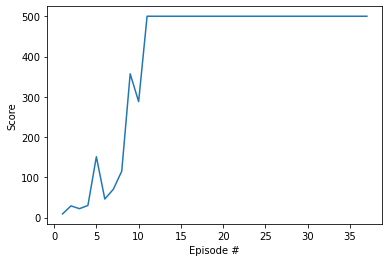

In [97]:
scores = CEM_Weights(agent=agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()